# InceptionV3 Model Transfer Learning

In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd

Input size must be at least 75x75; for InceptionV3

In [2]:
train_datagen = ImageDataGenerator(
        rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    directory=r"D:\SWOC-2024\DL-Simplified\High Throughput Algae Cell Detection\Dataset\alge_dataset\non_yolo",
    target_size=(75,75),
    color_mode="rgb",
    batch_size=64,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 1758 images belonging to 6 classes.


### Class Distribution

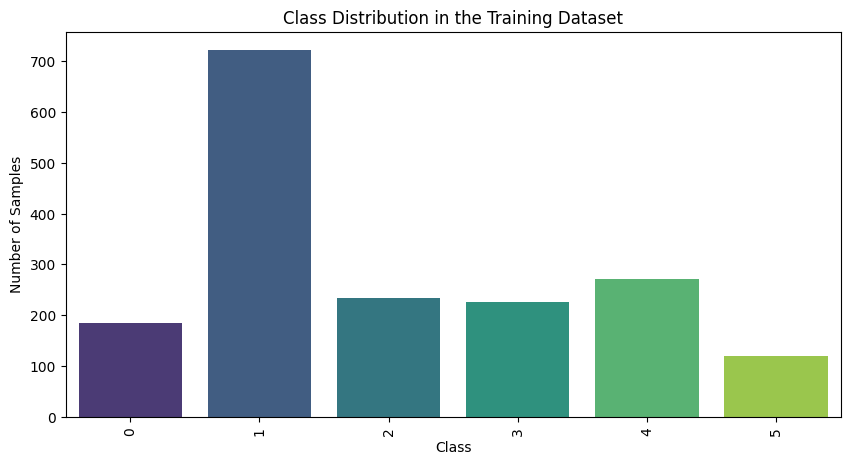

In [3]:
class_indices = train_generator.class_indices

class_names = {v: k for k, v in class_indices.items()}

class_distribution = train_generator.classes

class_names_list = [class_names[class_idx] for class_idx in class_distribution]

# Plot the class distribution using Seaborn
plt.figure(figsize=(10, 5))
sns.countplot(x=class_names_list, palette='viridis')
plt.title('Class Distribution in the Training Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation='vertical')
plt.show()

In [4]:
class_labels = train_generator.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(class_labels), y=class_labels)

print("Class Weights:", class_weights)


Class Weights: [1.5923913  0.40581717 1.25213675 1.2907489  1.07720588 2.46218487]


In [5]:
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
class_weight_dict

{0: 1.5923913043478262,
 1: 0.40581717451523547,
 2: 1.2521367521367521,
 3: 1.2907488986784141,
 4: 1.0772058823529411,
 5: 2.46218487394958}

- ##### This inverse proportion from our original distribution indicates Class_weight multiple requires for all class

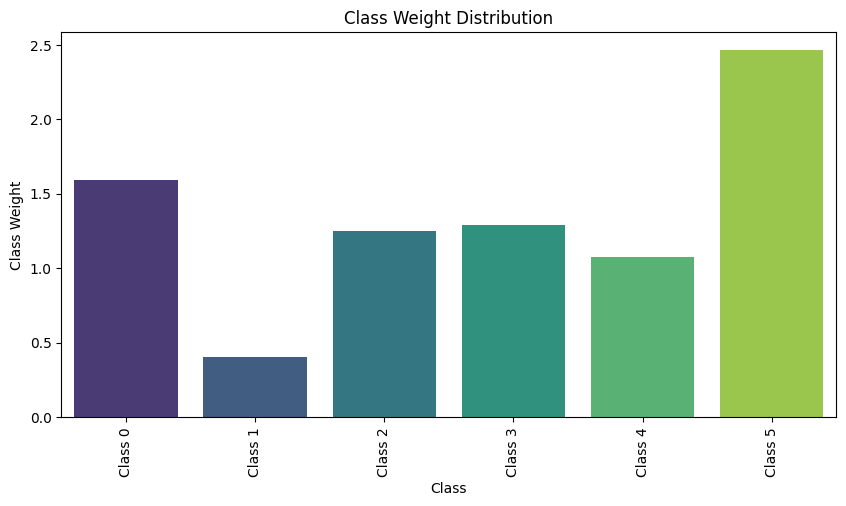

In [6]:
class_weights = [1.5923913, 0.40581717, 1.25213675, 1.2907489, 1.07720588, 2.46218487]
class_names_list = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5']

# Create a DataFrame for Seaborn
data = {'Class': class_names_list, 'Weight': class_weights}
df = pd.DataFrame(data)
# Plot the class distribution using Seaborn
plt.figure(figsize=(10, 5))
sns.barplot(x='Class', y='Weight', data=df, palette='viridis')
plt.title('Class Weight Distribution')
plt.xlabel('Class')
plt.ylabel('Class Weight')
plt.xticks(rotation='vertical')
plt.show()

- Ploting from majority classes which have relatively poor resolution

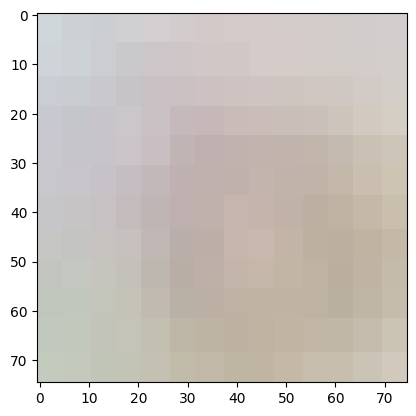

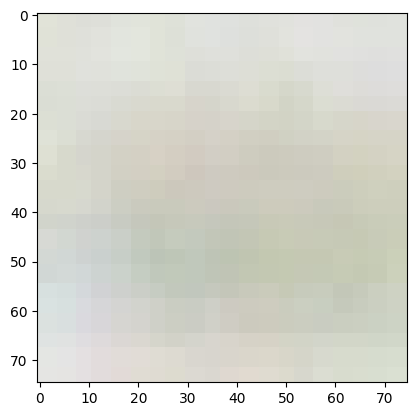

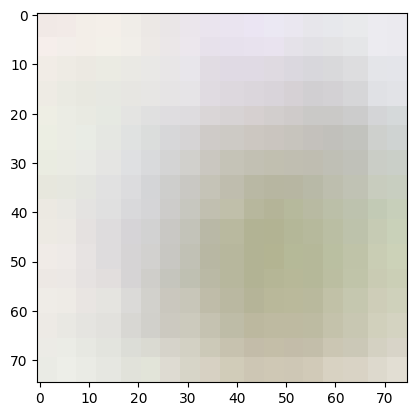

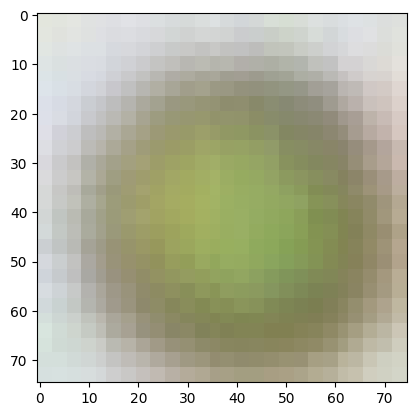

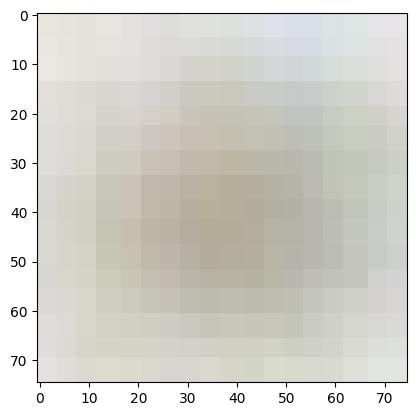

In [18]:
for _ in range(10):
    img, label = train_generator.next()
    if (label[0][1]==1):
        plt.imshow(img[0])
    plt.show()

In [8]:
base_model=InceptionV3(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(75,75,3),
    pooling=None,
    classes=6,
    classifier_activation="softmax",
)

In [9]:
for layer in base_model.layers:
    layer.trainable = False

In [10]:
InceptionV3_learner=models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(6, activation='softmax')
])

In [11]:
InceptionV3_learner.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 22,328,870
Trainable params: 526,086
Non-trainable params: 21,802,784
______________________________________

In [12]:
METRICS = [
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [13]:
InceptionV3_learner.compile(
    optimizer=Adam(lr=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy', METRICS],
)

c:\Users\arpit\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [14]:
InceptionV3_history=InceptionV3_learner.fit(train_generator,epochs=100,class_weight=class_weight_dict)

Epoch 1/100
28/28 [==============================] - 9s 32ms/step - loss: 1.6648 - accuracy: 0.4187 - precision: 0.6679 - recall: 0.2059 - auc: 0.7528 - prc: 0.4534
Epoch 2/100
28/28 [==============================] - 1s 32ms/step - loss: 1.0191 - accuracy: 0.6951 - precision: 0.8600 - recall: 0.4681 - auc: 0.9261 - prc: 0.7770
Epoch 3/100
28/28 [==============================] - 1s 25ms/step - loss: 0.8193 - accuracy: 0.7554 - precision: 0.8752 - recall: 0.6064 - auc: 0.9498 - prc: 0.8431
Epoch 4/100
28/28 [==============================] - 1s 25ms/step - loss: 0.7211 - accuracy: 0.7895 - precision: 0.8833 - recall: 0.6672 - auc: 0.9598 - prc: 0.8714
Epoch 5/100
28/28 [==============================] - 1s 26ms/step - loss: 0.6315 - accuracy: 0.8225 - precision: 0.8999 - recall: 0.7213 - auc: 0.9700 - prc: 0.9017
Epoch 6/100
28/28 [==============================] - 1s 26ms/step - loss: 0.5847 - accuracy: 0.8390 - precision: 0.9040 - recall: 0.7389 - auc: 0.9736 - prc: 0.9129
Epoch 7/10

In [16]:
df=pd.DataFrame(InceptionV3_history.history)
df.to_csv("InceptionV3_plot.csv",index=False)

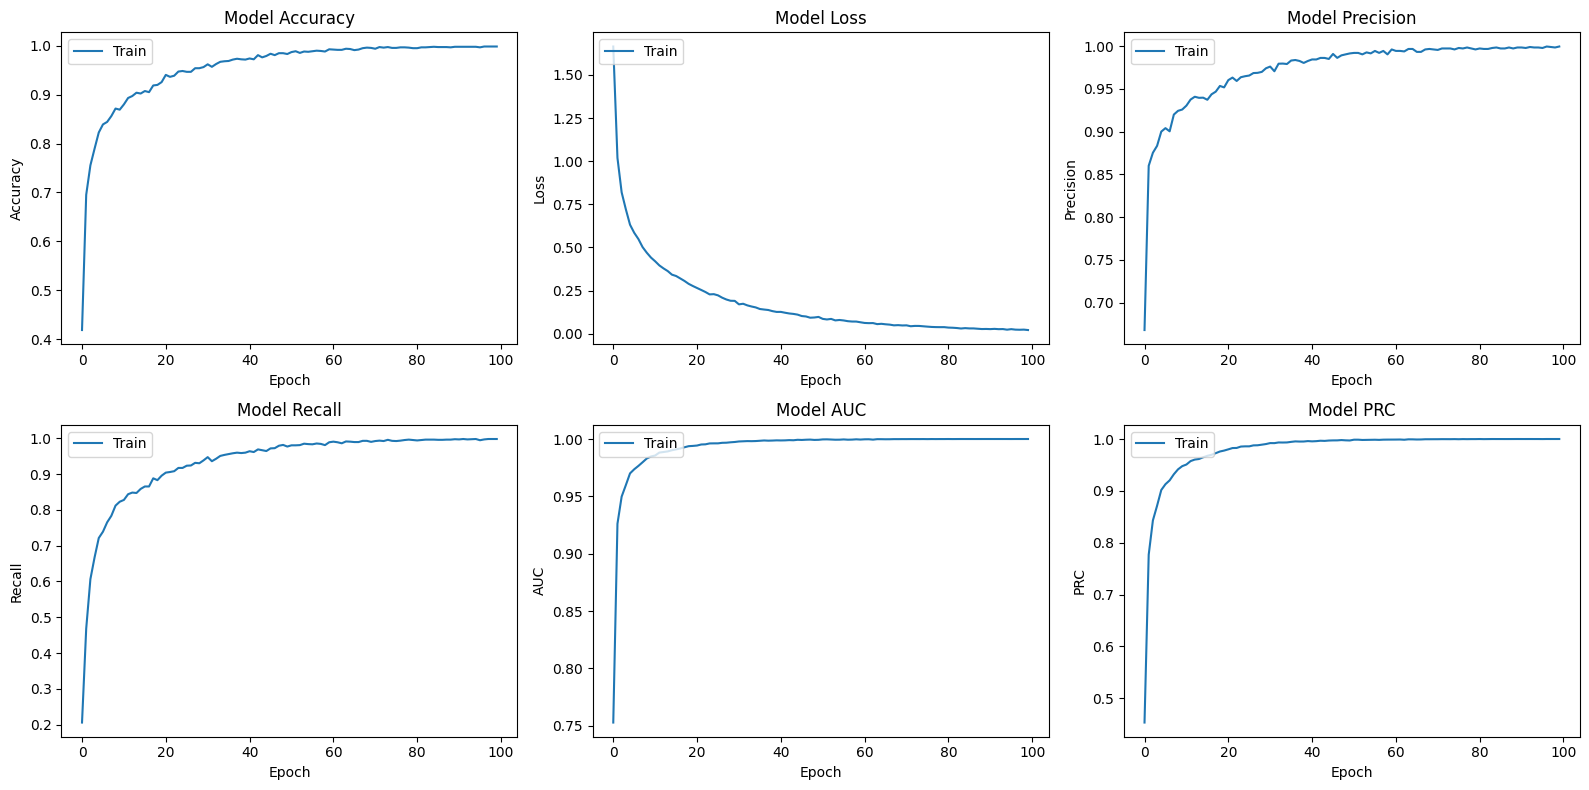

In [15]:
# Plot training history for multiple metrics
plt.figure(figsize=(16, 8))

# Plot training & validation accuracy values
plt.subplot(2, 3, 1)
plt.plot(InceptionV3_history.history['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train'], loc='upper left')

# Plot training & validation loss values
plt.subplot(2, 3, 2)
plt.plot(InceptionV3_history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train'], loc='upper left')

# Plot training & validation precision values
plt.subplot(2, 3, 3)
plt.plot(InceptionV3_history.history['precision'])
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Train'], loc='upper left')

# Plot training & validation recall values
plt.subplot(2, 3, 4)
plt.plot(InceptionV3_history.history['recall'])
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend(['Train'], loc='upper left')

# Plot training & validation AUC values
plt.subplot(2, 3, 5)
plt.plot(InceptionV3_history.history['auc'])
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(['Train'], loc='upper left')

# Plot training & validation PRC values
plt.subplot(2, 3, 6)
plt.plot(InceptionV3_history.history['prc'])
plt.title('Model PRC')
plt.xlabel('Epoch')
plt.ylabel('PRC')
plt.legend(['Train'], loc='upper left')

plt.tight_layout()
plt.show()